In [1]:
import pandas as pd
from typing import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

pd.set_option('display.max_columns', None)

# Rank cities by deficiency and fire occurence

In [2]:
df = pd.read_csv('../data/processed/nspire_nfirs_merge.csv')

Get number of null values per columns.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82609 entries, 0 to 82608
Data columns (total 32 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   CITYSTATE                                                82609 non-null  object 
 1   Count Carbon Monoxide Alarm                              293 non-null    float64
 2   Count Leak                                               425 non-null    float64
 3   Count Chimney                                            5 non-null      float64
 4   Count Door - Fire Labeled                                369 non-null    float64
 5   Count Electrical - Outlet and Switch                     746 non-null    float64
 6   Count Electrical - Conductor                             526 non-null    float64
 7   Count Electrical - Service Panel                         188 non-null    float64
 8   Count Electrical - GFCI or

Because we'll calculate per capita values, drop null population rows.

In [4]:
df = df[df.POPULATION.notna()]

Create a combined column for the following NSPIRE deficiencies.
* Sum smoke and carbon monoxide alarms
* Sum electrical deficiencies
* Sum all fire-related deficiencies

In [5]:
df['sum_alarm_nspire'] = df['Count Carbon Monoxide Alarm'] + \
                            df['Count Smoke Alarm']

In [6]:
df['sum_electrical_nspire'] = df['Count Electrical - Conductor'] + \
                                df['Count Electrical - GFCI or AFCI Outlet or Breaker'] + \
                                df['Count Electrical - Outlet and Switch'] + \
                                df['Count Electrical - Service Panel']

In [7]:
fire_standards = [
    "Count Carbon Monoxide Alarm",
    "Count Leak",
    "Count Chimney",
    "Count Door - Fire Labeled",
    "Count Electrical - Outlet and Switch",
    "Count Electrical - Conductor",
    "Count Electrical - Service Panel",
    "Count Electrical - GFCI or AFCI Outlet or Breaker",
    "Count Fire Escape",
    "Count Fire Extinguisher",
    "Count Flammable and Combustible Item",
    "Count Smoke Alarm",
    "Count Heating, Ventilation, and Air Conditioning (HVAC)",
    "Count Kitchen Ventilation",
    "Count Structural System"
]

df['sum_all_fire_nspire'] = df.loc[:, fire_standards].sum(axis=1)

Get population adjusted NFIRS counts

In [8]:
df['sum_loss'] = df['SUM_PROP_LOSS'] + df['SUM_CONT_LOSS']
df['sum_death'] = df['SUM_OTH_DEATH'] + df['SUM_FF_DEATH']
df['sum_injury'] = df['SUM_OTH_INJ'] + df['SUM_FF_INJ']

Calculate new adjusted values, per capita and per fire.

In [9]:
to_population_adjust = [
    'sum_loss', 'sum_death', 'sum_injury', 'TOTAL_INCIDENT_COUNT'
]

to_total_incident_count_adjust = [
    'COUNT_111','COUNT_111', 'COUNT_113',
    'COUNT_131', 'COUNT_151', 'COUNT_142', 'SUM_SPREAD'
]

for col in to_population_adjust:
    df['ADJ_' + col] = df[col] / df.POPULATION

for col in to_total_incident_count_adjust:
    df['ADJ_' + col] = df[col] / df.TOTAL_INCIDENT_COUNT

df['house_fires_per_capita'] = df['COUNT_111'] / df.POPULATION
df['cooking_fires_per_capita'] = df['COUNT_113'] / df.POPULATION

Rename columns for readability.

In [10]:
df = df.rename(columns={
    'ADJ_COUNT_111': 'sum_111_per_fire', 
    'ADJ_COUNT_113': 'sum_113_per_fire', 
    'ADJ_COUNT_131': 'sum_131_per_fire', 
    'ADJ_COUNT_151': 'sum_151_per_fire', 
    'ADJ_COUNT_142': 'sum_142_per_fire', 
    'ADJ_SUM_SPREAD': 'sum_secondary_fires_per_fire',
    'ADJ_sum_loss': 'money_lost_per_capita',
    'ADJ_sum_death': 'deaths_per_capita',
    'ADJ_sum_injury': 'injuries_per_capita',
    'ADJ_TOTAL_INCIDENT_COUNT': 'fires_per_capita'
})

### Pairplots of NSPIRE data with deaths per capita

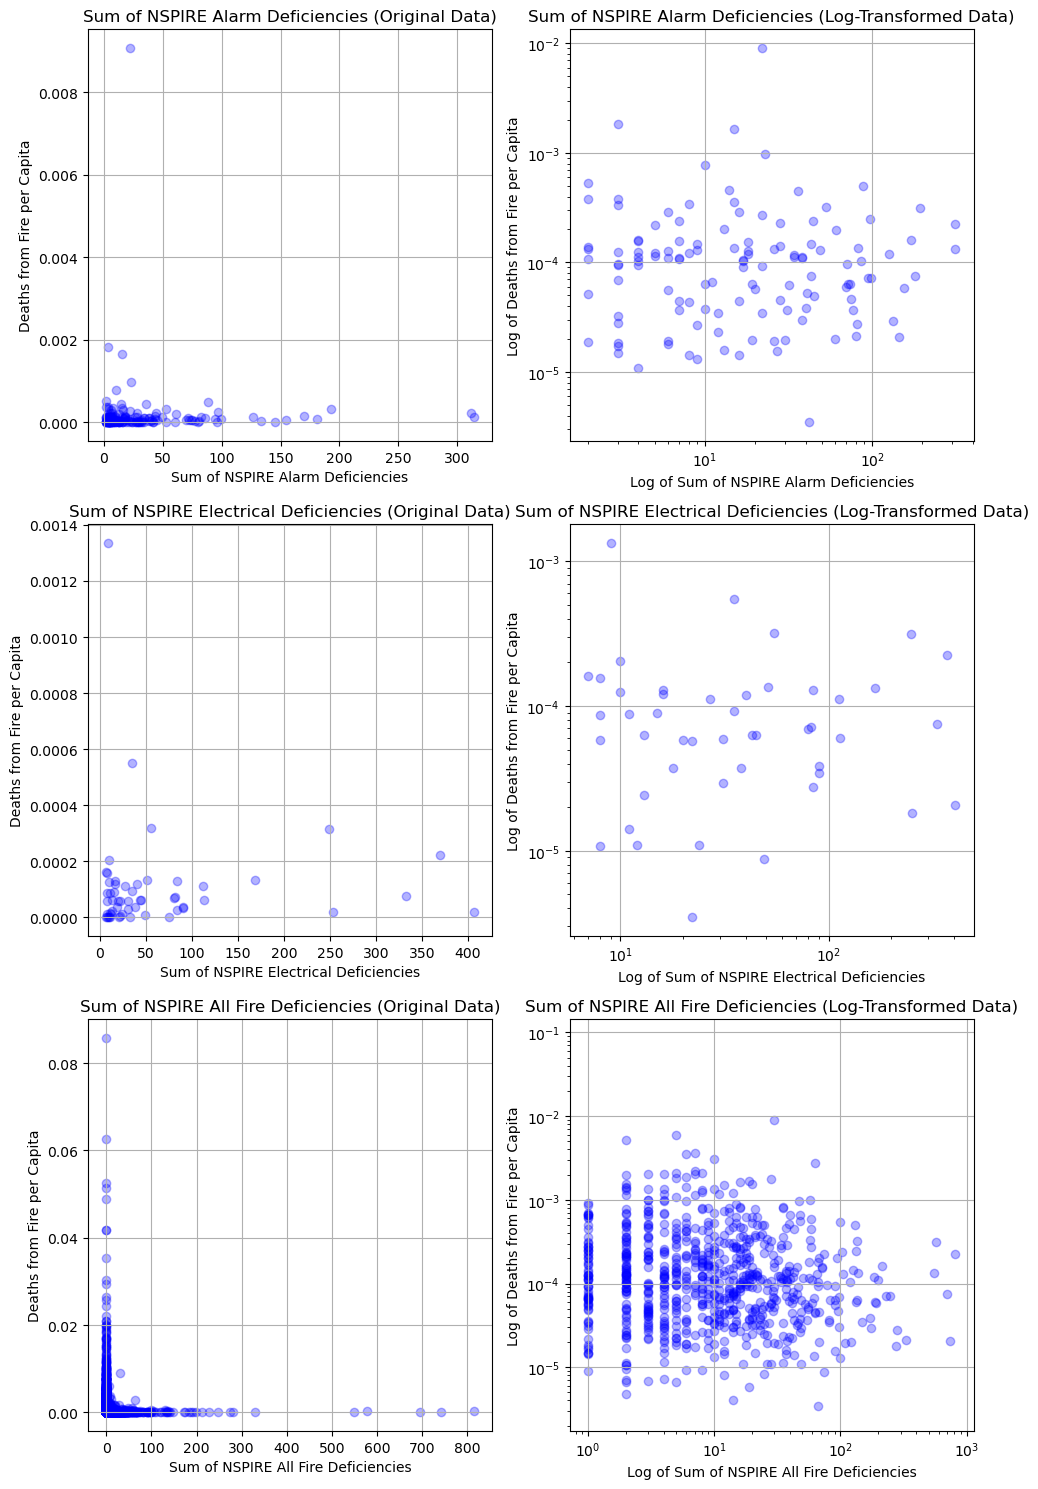

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15)) 

x_variables = [
    'sum_alarm_nspire',
    'sum_electrical_nspire',
    'sum_all_fire_nspire',
]

x_descriptions = [
    'Sum of NSPIRE Alarm Deficiencies',
    'Sum of NSPIRE Electrical Deficiencies',
    'Sum of NSPIRE All Fire Deficiencies',
]

for i, x_var in enumerate(x_variables):
    axes[i, 0].scatter(df[x_var], df['deaths_per_capita'], color='blue', alpha=.3)
    axes[i, 0].set_title(f'{x_descriptions[i]} (Original Data)')
    axes[i, 0].set_xlabel(x_descriptions[i])
    axes[i, 0].set_ylabel('Deaths from Fire per Capita')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df[x_var], df['deaths_per_capita'], color='blue', alpha=.3)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_title(f'{x_descriptions[i]} (Log-Transformed Data)')
    axes[i, 1].set_xlabel(f'Log of {x_descriptions[i]}')
    axes[i, 1].set_ylabel('Log of Deaths from Fire per Capita')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

### Pairplots of the NSPIRE data with house fires per capita

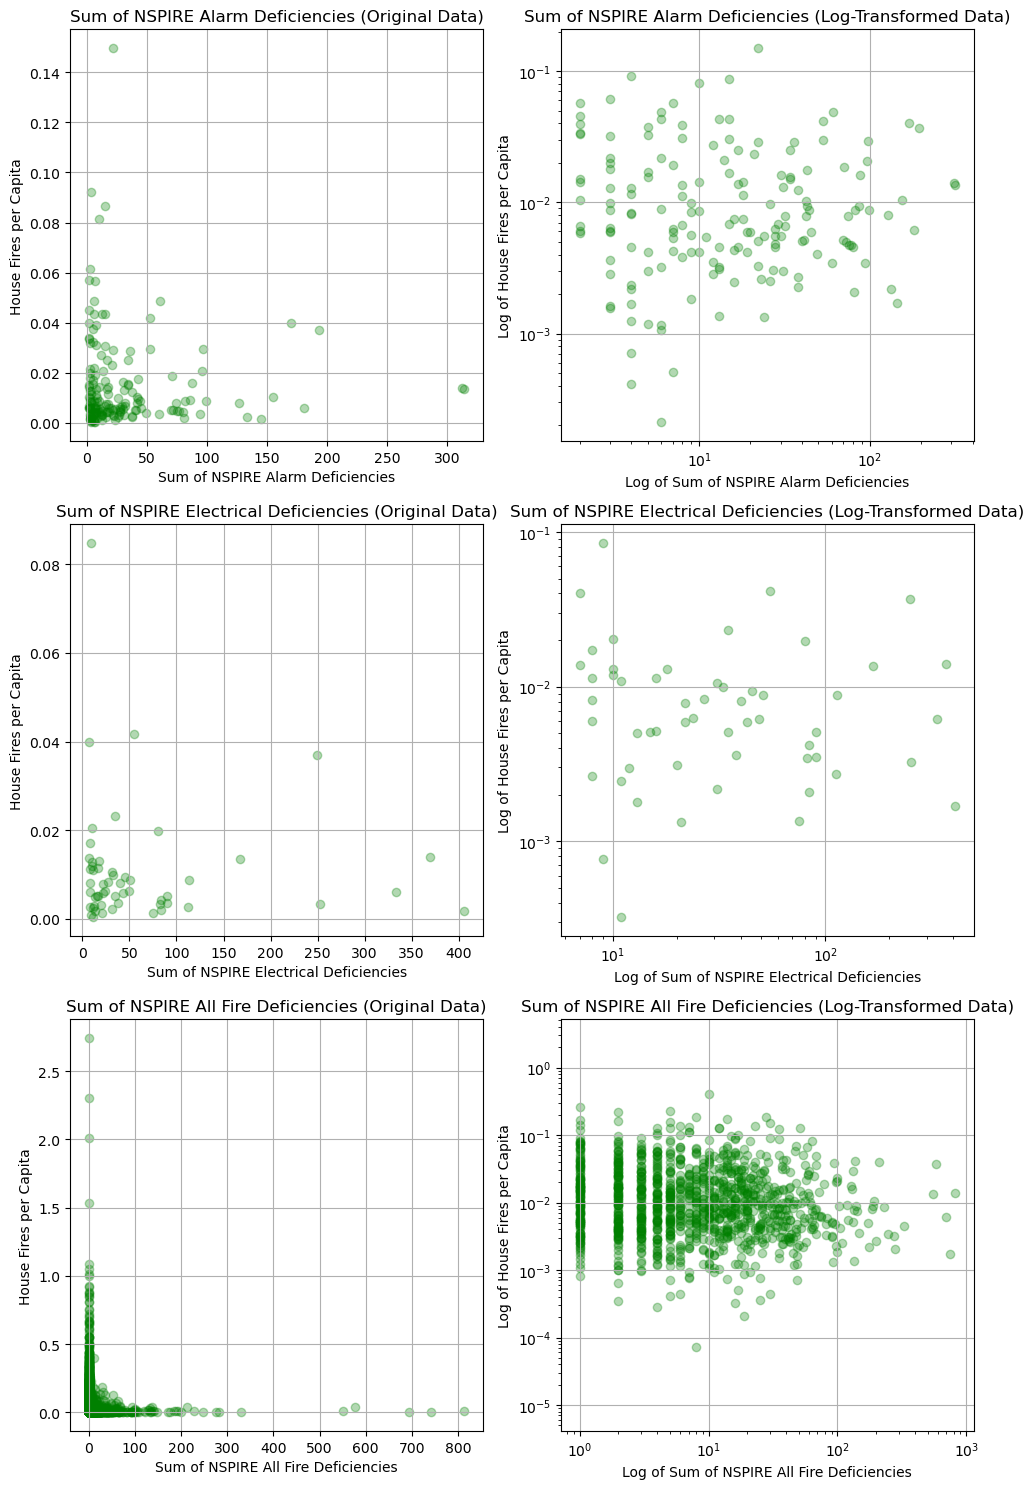

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15)) 

x_variables = [
    'sum_alarm_nspire',
    'sum_electrical_nspire',
    'sum_all_fire_nspire',
]

x_descriptions = [
    'Sum of NSPIRE Alarm Deficiencies',
    'Sum of NSPIRE Electrical Deficiencies',
    'Sum of NSPIRE All Fire Deficiencies',
]

for i, x_var in enumerate(x_variables):
    axes[i, 0].scatter(df[x_var], df['house_fires_per_capita'], color='green', alpha=.3)
    axes[i, 0].set_title(f'{x_descriptions[i]} (Original Data)')
    axes[i, 0].set_xlabel(x_descriptions[i])
    axes[i, 0].set_ylabel('House Fires per Capita')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df[x_var], df['house_fires_per_capita'], color='green', alpha=.3)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_title(f'{x_descriptions[i]} (Log-Transformed Data)')
    axes[i, 1].set_xlabel(f'Log of {x_descriptions[i]}')
    axes[i, 1].set_ylabel('Log of House Fires per Capita')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

### Pairplots against NSPIRE alarms

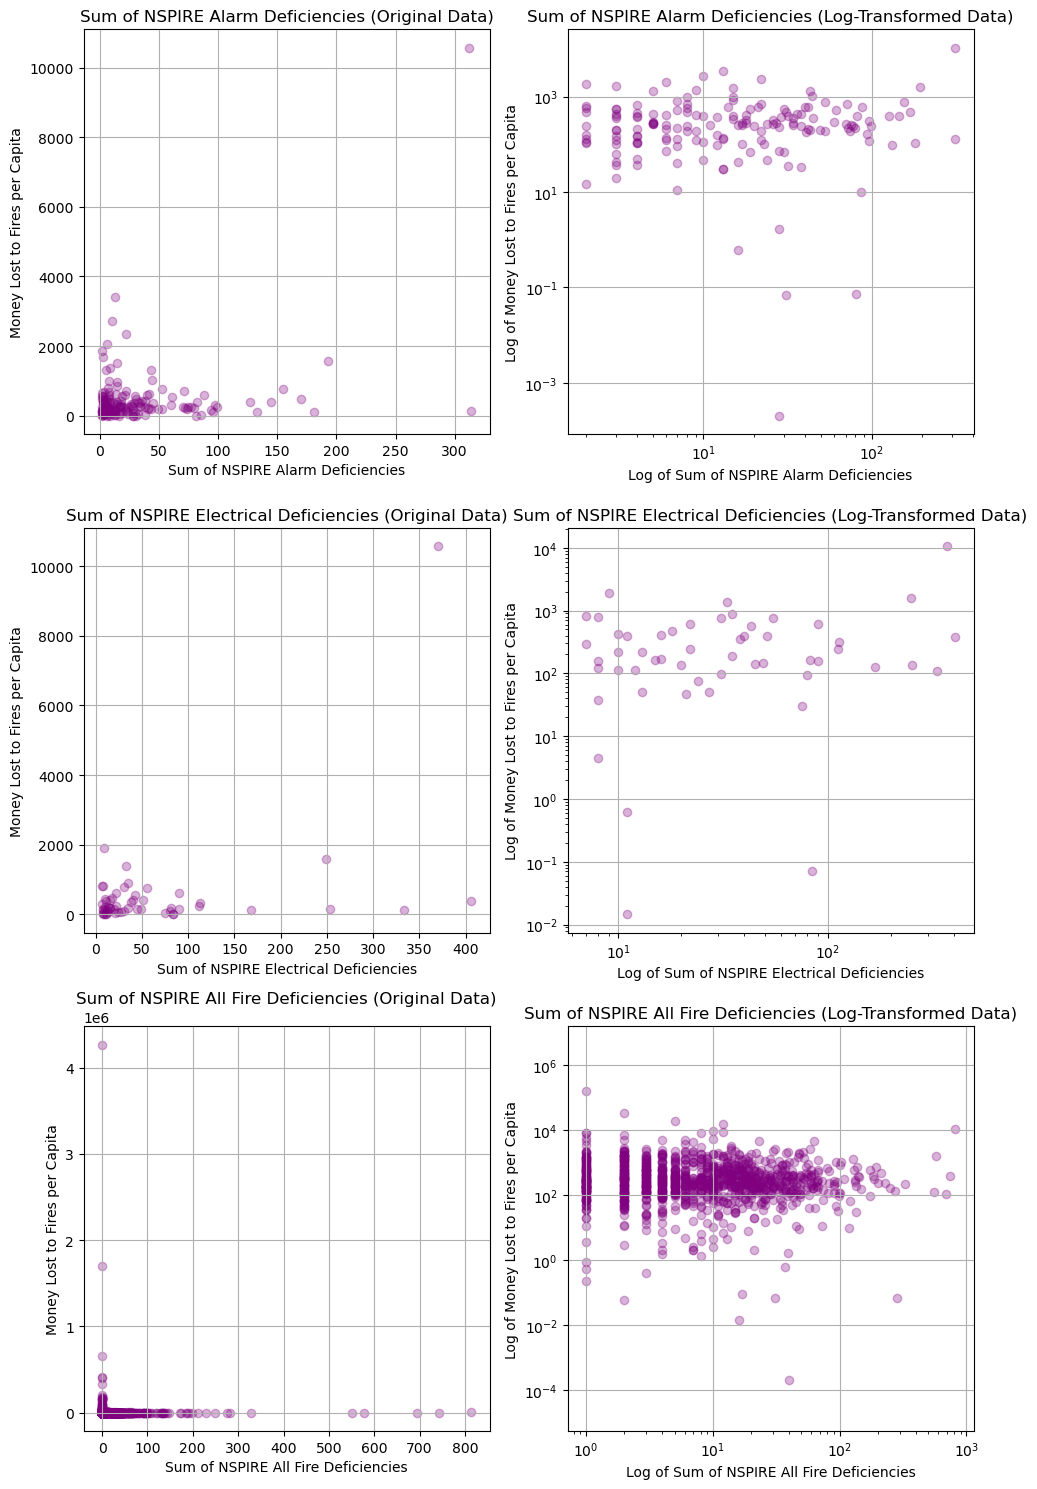

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15)) 

x_variables = [
    'sum_alarm_nspire',
    'sum_electrical_nspire',
    'sum_all_fire_nspire',
]

x_descriptions = [
    'Sum of NSPIRE Alarm Deficiencies',
    'Sum of NSPIRE Electrical Deficiencies',
    'Sum of NSPIRE All Fire Deficiencies',
]

for i, x_var in enumerate(x_variables):
    axes[i, 0].scatter(df[x_var], df['money_lost_per_capita'], color='purple', alpha=.3)
    axes[i, 0].set_title(f'{x_descriptions[i]} (Original Data)')
    axes[i, 0].set_xlabel(x_descriptions[i])
    axes[i, 0].set_ylabel('Money Lost to Fires per Capita')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df[x_var], df['money_lost_per_capita'], color='purple', alpha=.3)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_title(f'{x_descriptions[i]} (Log-Transformed Data)')
    axes[i, 1].set_xlabel(f'Log of {x_descriptions[i]}')
    axes[i, 1].set_ylabel('Log of Money Lost to Fires per Capita')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

### Pairplot of NSPIRE alarms

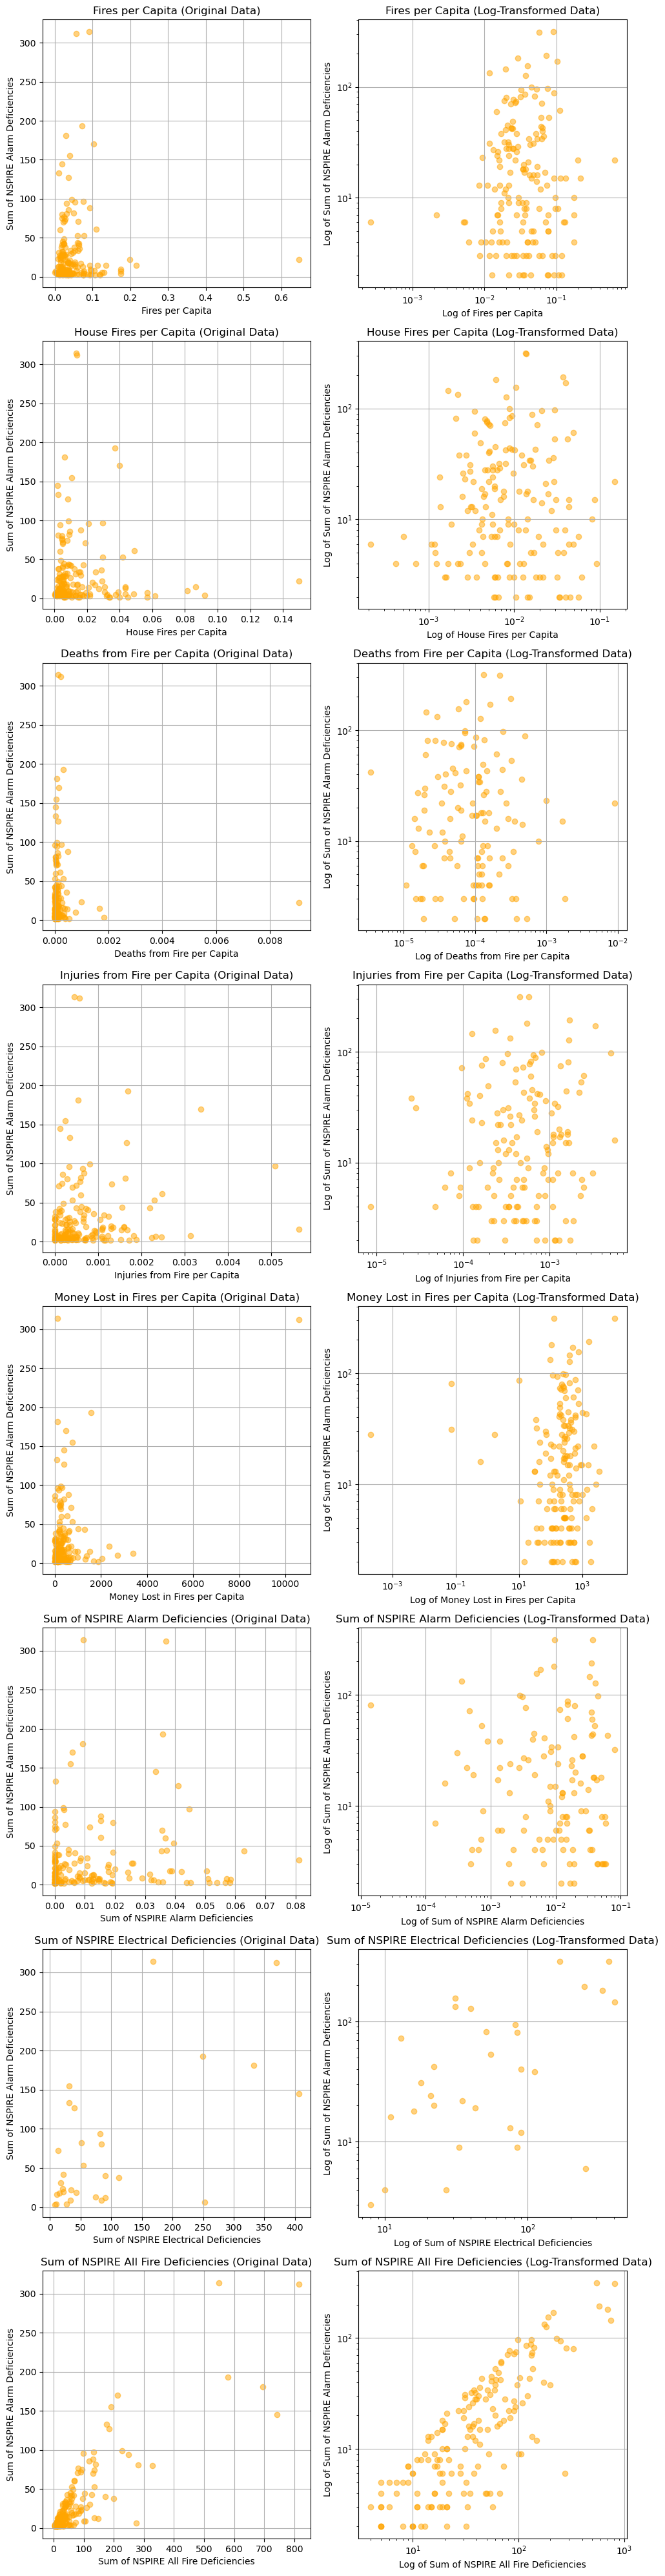

In [14]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40)) 

x_variables = [
    'fires_per_capita',
    'house_fires_per_capita',
    'deaths_per_capita',
    'injuries_per_capita',
    'money_lost_per_capita',
    'sum_secondary_fires_per_fire',
    'sum_electrical_nspire',
    'sum_all_fire_nspire'
]

x_descriptions = [
    'Fires per Capita',
    'House Fires per Capita',
    'Deaths from Fire per Capita',
    'Injuries from Fire per Capita',
    'Money Lost in Fires per Capita',
    'Sum of NSPIRE Alarm Deficiencies',
    'Sum of NSPIRE Electrical Deficiencies',
    'Sum of NSPIRE All Fire Deficiencies',
]

for i, x_var in enumerate(x_variables):
    axes[i, 0].scatter(df[x_var], df['sum_alarm_nspire'], color='orange', alpha=.5)
    axes[i, 0].set_title(f'{x_descriptions[i]} (Original Data)')
    axes[i, 0].set_xlabel(x_descriptions[i])
    axes[i, 0].set_ylabel('Sum of NSPIRE Alarm Deficiencies')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df[x_var], df['sum_alarm_nspire'], color='orange', alpha=.5)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_title(f'{x_descriptions[i]} (Log-Transformed Data)')
    axes[i, 1].set_xlabel(f'Log of {x_descriptions[i]}')
    axes[i, 1].set_ylabel('Log of Sum of NSPIRE Alarm Deficiencies')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

### Pairplots of NFIRS data vs deaths per capita

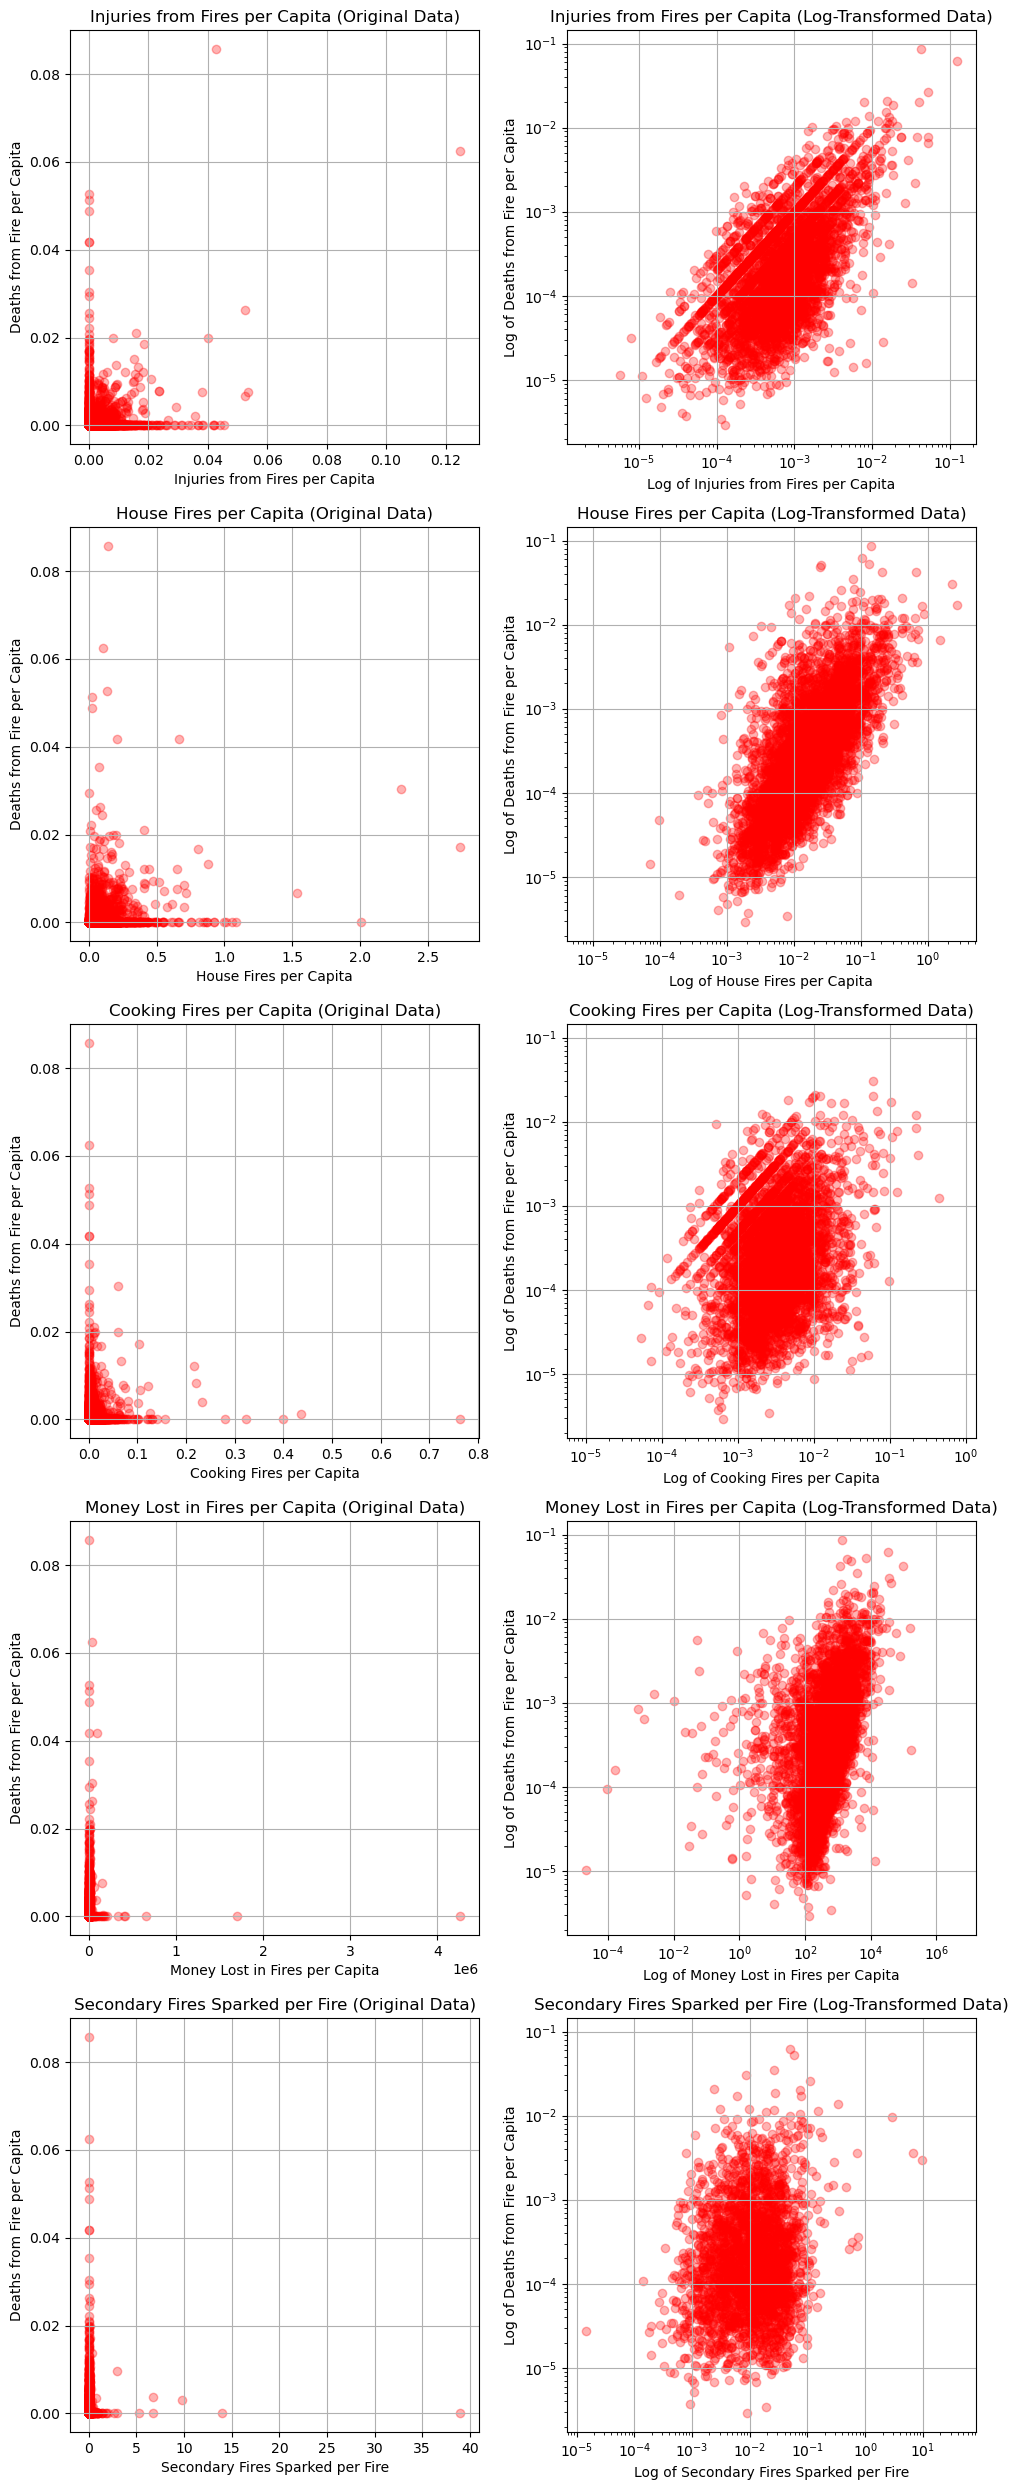

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 25)) 

x_variables = [
    'injuries_per_capita',
    'house_fires_per_capita',
    'cooking_fires_per_capita',
    'money_lost_per_capita',
    'sum_secondary_fires_per_fire'
]

x_descriptions = [
    'Injuries from Fires per Capita',
    'House Fires per Capita',
    'Cooking Fires per Capita',
    'Money Lost in Fires per Capita',
    'Secondary Fires Sparked per Fire'
]

for i, x_var in enumerate(x_variables):
    axes[i, 0].scatter(df[x_var], df['deaths_per_capita'], color='red', alpha=.3)
    axes[i, 0].set_title(f'{x_descriptions[i]} (Original Data)')
    axes[i, 0].set_xlabel(x_descriptions[i])
    axes[i, 0].set_ylabel('Deaths from Fire per Capita')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df[x_var], df['deaths_per_capita'], color='red', alpha=.3)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_title(f'{x_descriptions[i]} (Log-Transformed Data)')
    axes[i, 1].set_xlabel(f'Log of {x_descriptions[i]}')
    axes[i, 1].set_ylabel('Log of Deaths from Fire per Capita')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

# Ranking cities using NFIRS data

Add ordinal rankings for each city.

In [16]:
df['deaths_per_capita_rank'] = df['deaths_per_capita'].rank()
df['injuries_per_capita_rank'] = df['injuries_per_capita'].rank()
df['house_fires_per_capita_rank'] = df['house_fires_per_capita'].rank()

## Use year-by-year ranking stability to validate index choices